# Flights Cancelled or Delayed by Airline Reservation System Problems

By Josh Romero

An initial analysis to see whether it's possible to match specific cancellations and delays to incidents reported in the news.

In [122]:
import pandas as pd

from datetime import date
import numpy as np

import leather
import matplotlib.pyplot as plt

%matplotlib inline

Use the "[On-Time: On-Time Performance](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time)" database from TranStats (Bureau of Transportation Statistics) to find delayed and cancelled flights. To prototype, we'll start by looking at just one month (Jan 2017).

In [123]:
flight_data = 'raw_data/On_Time_On_Time_Performance_2017_1.csv'

The database of flights is quite large, with lots of columns we don't need (at least for now). Here is a list of the columns that seem like they'll be useful from the [table contents](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time).

In [124]:
cols = [
    5,6,10,11,14,23,29,30,31,32,36,37,38,39,
    40,41,42,43,47,48,49,56,57,58,59,60
]

We'll load the CSV data in chunks to avoid overloading the memory.

In [147]:
iter_csv = pd.read_csv(
        flight_data, iterator=True, chunksize=1000, usecols=cols
    )

Keep just the flights (rows) that were cancelled or had carrier delays (ignore delays due to weather, air traffic control systems, or missing planes).

In [148]:
cancelled_or_delayed = pd.concat([chunk[(
        chunk['Cancelled'] > 0
    ) | (
        chunk['CarrierDelay'] > 0
    )] for chunk in iter_csv])

cancelled = cancelled_or_delayed[cancelled_or_delayed['Cancelled'] > 0]
delayed = cancelled_or_delayed[cancelled_or_delayed['CarrierDelay'] > 0]

First, let's see which carriers had the most cancelled flights this month.

In [149]:
carrier_group_ca = cancelled[[
        'UniqueCarrier','FlightDate','Cancelled'
    ]].groupby('UniqueCarrier')

carrier_group_ca.size().sort_values(ascending=False).reset_index()

,UniqueCarrier,0
0,WN,2313
1,OO,1880
2,EV,1159
3,AA,980
4,DL,782
5,B6,525
6,NK,441
7,AS,257
8,UA,232
9,F9,162


Next, let's see when those cancellations occured for each carrier

In [151]:
cancelled_by_date = cancelled[[
        'UniqueCarrier','FlightDate','Cancelled'
    ]].groupby(['FlightDate','UniqueCarrier']).agg(np.sum).unstack()
# cancelled_by_date

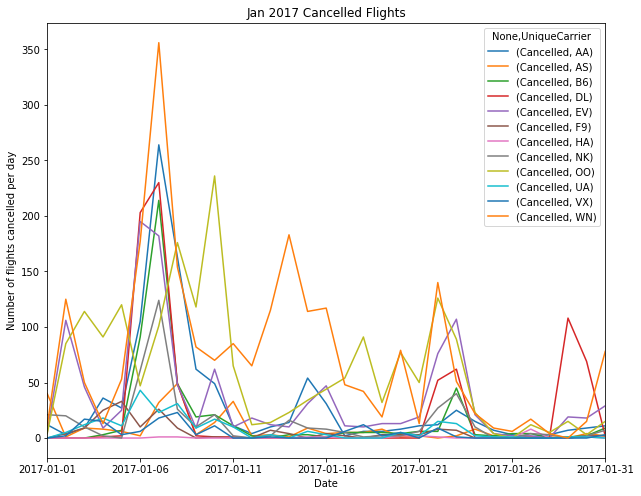

In [152]:
cancel_plot = cancelled_by_date.fillna(0).plot(
        figsize=(10, 8), title="Jan 2017 Cancelled Flights"
    )
cancel_plot.set_ylabel('Number of flights cancelled per day')
cancel_plot.set_xlabel('Date')

It looks like WN (Soutwest) struggled with cancellations througout the month, as did OO (SkyWest) to a lesser extent. There's some other notable cancellation spikes for individual airlines, but it looks like many carriers had probems around January 7th. Let's see a the aggregate:

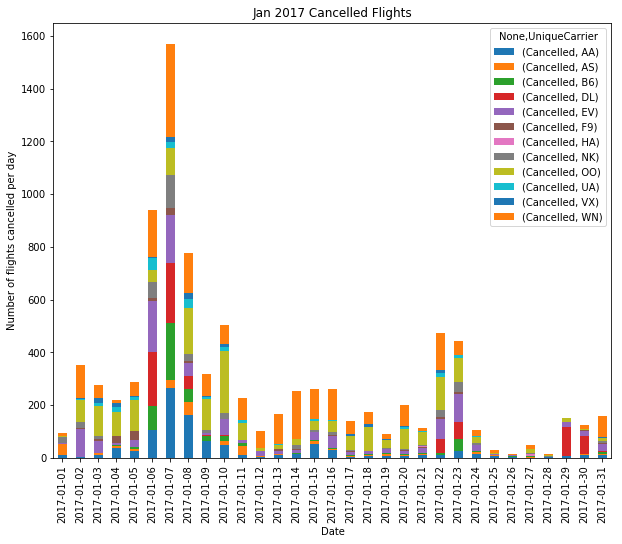

In [153]:
cancel_plot = cancelled_by_date.fillna(0).plot(
        kind='bar', stacked=True, figsize=(10, 8),
        title="Jan 2017 Cancelled Flights"
    )
cancel_plot.set_ylabel('Number of flights cancelled per day')
cancel_plot.set_xlabel('Date')

January 6-8 saw a large number of cancellations, and the last week of the month was much better the first three.

Now let's turn to delays

In [154]:
delayed.head()

,FlightDate,UniqueCarrier,FlightNum,OriginAirportID,Origin,Dest,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,...,ArrDelay,ArrDelayMinutes,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
3,2017-01-20,AA,494,11057,CLT,PHX,1619,1656.0,37.0,37.0,...,33.0,33.0,0.0,NaN,0.0,33.0,0.0,0.0,0.0,0.0
23,2017-01-22,AA,494,11697,FLL,CLT,1305,1350.0,45.0,45.0,...,36.0,36.0,0.0,NaN,0.0,8.0,0.0,0.0,0.0,28.0
33,2017-01-04,AA,494,14635,RSW,CLT,1315,1338.0,23.0,23.0,...,20.0,20.0,0.0,NaN,0.0,20.0,0.0,0.0,0.0,0.0
44,2017-01-07,AA,495,10397,ATL,PHX,1130,1251.0,81.0,81.0,...,153.0,153.0,0.0,NaN,0.0,81.0,0.0,72.0,0.0,0.0
64,2017-01-11,AA,495,14122,PIT,PHX,1001,1011.0,10.0,10.0,...,20.0,20.0,0.0,NaN,0.0,10.0,0.0,10.0,0.0,0.0


Again, let's start by seeing which airlines had the most delayed flights.

In [155]:
carrier_group_de = delayed[[
        'UniqueCarrier','FlightDate','CarrierDelay'
    ]].groupby('UniqueCarrier')
carrier_group_de.size().sort_values(ascending=False).reset_index()

,UniqueCarrier,0
0,WN,13488
1,AA,7268
2,DL,6555
3,UA,4656
4,B6,4248
5,OO,4145
6,EV,4099
7,F9,1154
8,AS,859
9,HA,762


No surprise that Southwest had the most delays as well. But with delays, we should also consider the duration of delays, not just their frequency.

In [144]:
delay_totals = carrier_group_de.sum()
delay_totals.sort_values('CarrierDelay', ascending=False)

,CarrierDelay
UniqueCarrier,
DL,385953.0
EV,299209.0
WN,291141.0
OO,291017.0
AA,262291.0
UA,189305.0
B6,123024.0
F9,36930.0
AS,34787.0


Looks like DL (Delta) and EV (Express Jet) had delays that lasted much longer. Let's look at aggregate delays by date.

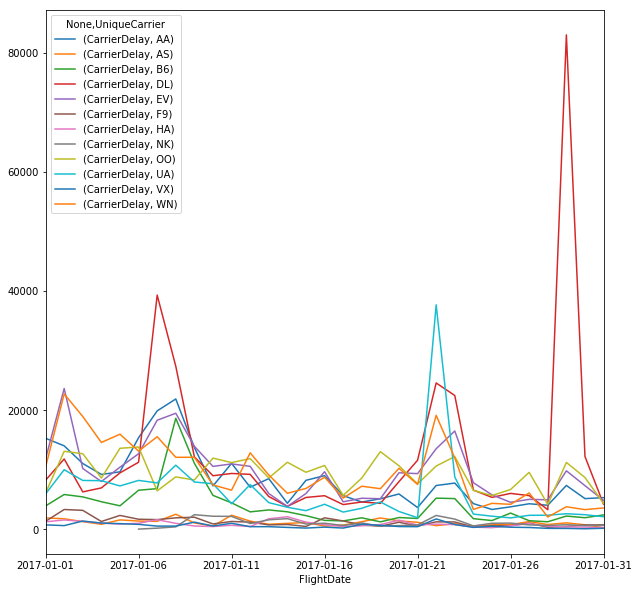

In [157]:
delayed[[
        'UniqueCarrier','FlightDate','CarrierDelay'
    ]].groupby([
        'FlightDate','UniqueCarrier'
    ]).agg(np.sum).unstack().plot(figsize=(10, 10))

Here we can see some large spikes that look like they may be carrier-specific. Delta had at leat two major incidents, and United had one.

In [160]:
united_flights_de = delayed[delayed.UniqueCarrier == 'UA']

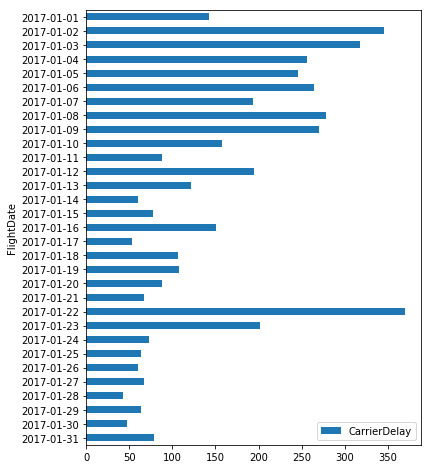

In [163]:
uf_dates_de = (
        united_flights_de.groupby('FlightDate', as_index=True)
        .count()
        .plot(kind='barh', y="CarrierDelay", figsize=(6, 8))
        .invert_yaxis() # https://stackoverflow.com/questions/2051744/reverse-y-axis-in-pyplot
    )

# uf_dates = united_flights.FlightDate.value_counts().reset_index().sort_values('index')
# uf_dates

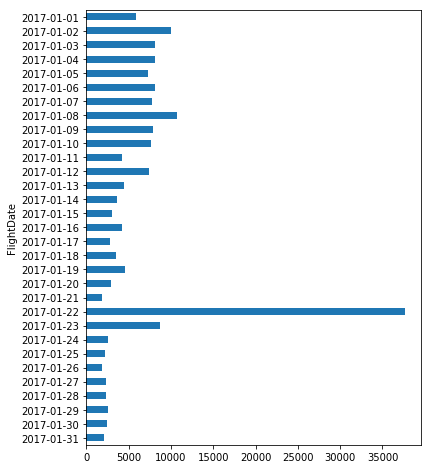

In [41]:
uf_dates = united_flights.groupby('FlightDate', as_index=True).CarrierDelay.sum().plot(kind='barh', y="CarrierDelay", figsize=(6, 8)).invert_yaxis()
